In [35]:
#importing the libraries and reading the data
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats


In [36]:
#reading the data
df = pd.read_csv('spotify_Song_Dataset/dataset.csv')

#removing the row with null values
df = df.dropna()

#dropping duration and explicit columns 
df = df.drop(['duration_ms','explicit','mode','liveness','loudness','time_signature','key'],axis=1)

df.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)


df.head(5)


,song_id,track_id,artists,album_name,track_name,popularity,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,0.676,0.4610,0.1430,0.0322,0.000001,0.715,87.917,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,0.420,0.1660,0.0763,0.9240,0.000006,0.267,77.489,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,0.438,0.3590,0.0557,0.2100,0.000000,0.120,76.332,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,0.266,0.0596,0.0363,0.9050,0.000071,0.143,181.740,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,0.618,0.4430,0.0526,0.4690,0.000000,0.167,119.949,acoustic


In [40]:
# Scaling the audio features and popularity
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])

# Add the original columns back to the DataFrame
df_scaled['song_id'] = df['song_id']
df_scaled['track_id'] = df['track_id']
df_scaled['artist_name'] = df['artists']
df_scaled['track_name'] = df['track_name']
df_scaled['album_name'] = df['album_name']
df_scaled['track_genre'] = df['track_genre']

# Encoding the track_genre
label_encoder = LabelEncoder()
df_scaled['track_genre_encoded'] = label_encoder.fit_transform(df['track_genre'])

# Handling outliers
z_scores = stats.zscore(df_scaled[['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']])
outliers = (z_scores > 3) | (z_scores < -3)
df_scaled = df_scaled[(~outliers).all(axis=1)]

# Handling missing data
df_scaled = df_scaled.dropna() 

# Re-scaling the audio features and popularity after handling outliers
scaled_features = scaler.fit_transform(df_scaled[['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']])
df_scaled[['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']] = scaled_features

#dropping missing values
df_scaled = df_scaled.dropna()

# Display the final processed DataFrame
df_scaled.head(5)


,popularity,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,song_id,track_id,artist_name,track_name,album_name,track_genre,track_genre_encoded
0,1.771385,0.631139,-0.718850,1.042944,-0.841377,-0.507338,0.926583,-1.171923,0.0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,acoustic,0
1,0.968000,-0.850328,-1.892423,0.032159,1.852071,-0.507323,-0.801100,-1.526016,1.0,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost - Acoustic,Ghost (Acoustic),acoustic,0
2,1.057265,-0.746162,-1.124628,-0.280018,-0.304379,-0.507341,-1.367996,-1.565303,2.0,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,acoustic,0
3,1.682120,-1.741522,-2.315705,-0.574009,1.794686,-0.507113,-1.279298,2.013922,3.0,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Can't Help Falling In Love,Crazy Rich Asians (Original Motion Picture Sou...,acoustic,0
4,2.173077,0.295494,-0.790458,-0.326996,0.477862,-0.507341,-1.186744,-0.084248,4.0,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,acoustic,0


In [43]:
print(df_scaled.info())

#duplicate values
duplicate = df_scaled.duplicated()

print(duplicate.sum())

#dropping duplicate values
df_scaled = df_scaled.drop_duplicates()


<class 'pandas.core.frame.DataFrame'>
Index: 111719 entries, 0 to 113998
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   popularity           111719 non-null  float64
 1   danceability         111719 non-null  float64
 2   energy               111719 non-null  float64
 3   speechiness          111719 non-null  float64
 4   acousticness         111719 non-null  float64
 5   instrumentalness     111719 non-null  float64
 6   valence              111719 non-null  float64
 7   tempo                111719 non-null  float64
 8   song_id              111719 non-null  float64
 9   track_id             111719 non-null  object 
 10  artist_name          111719 non-null  object 
 11  track_name           111719 non-null  object 
 12  album_name           111719 non-null  object 
 13  track_genre          111719 non-null  object 
 14  track_genre_encoded  111719 non-null  int64  
dtypes: float64(9), int64(1

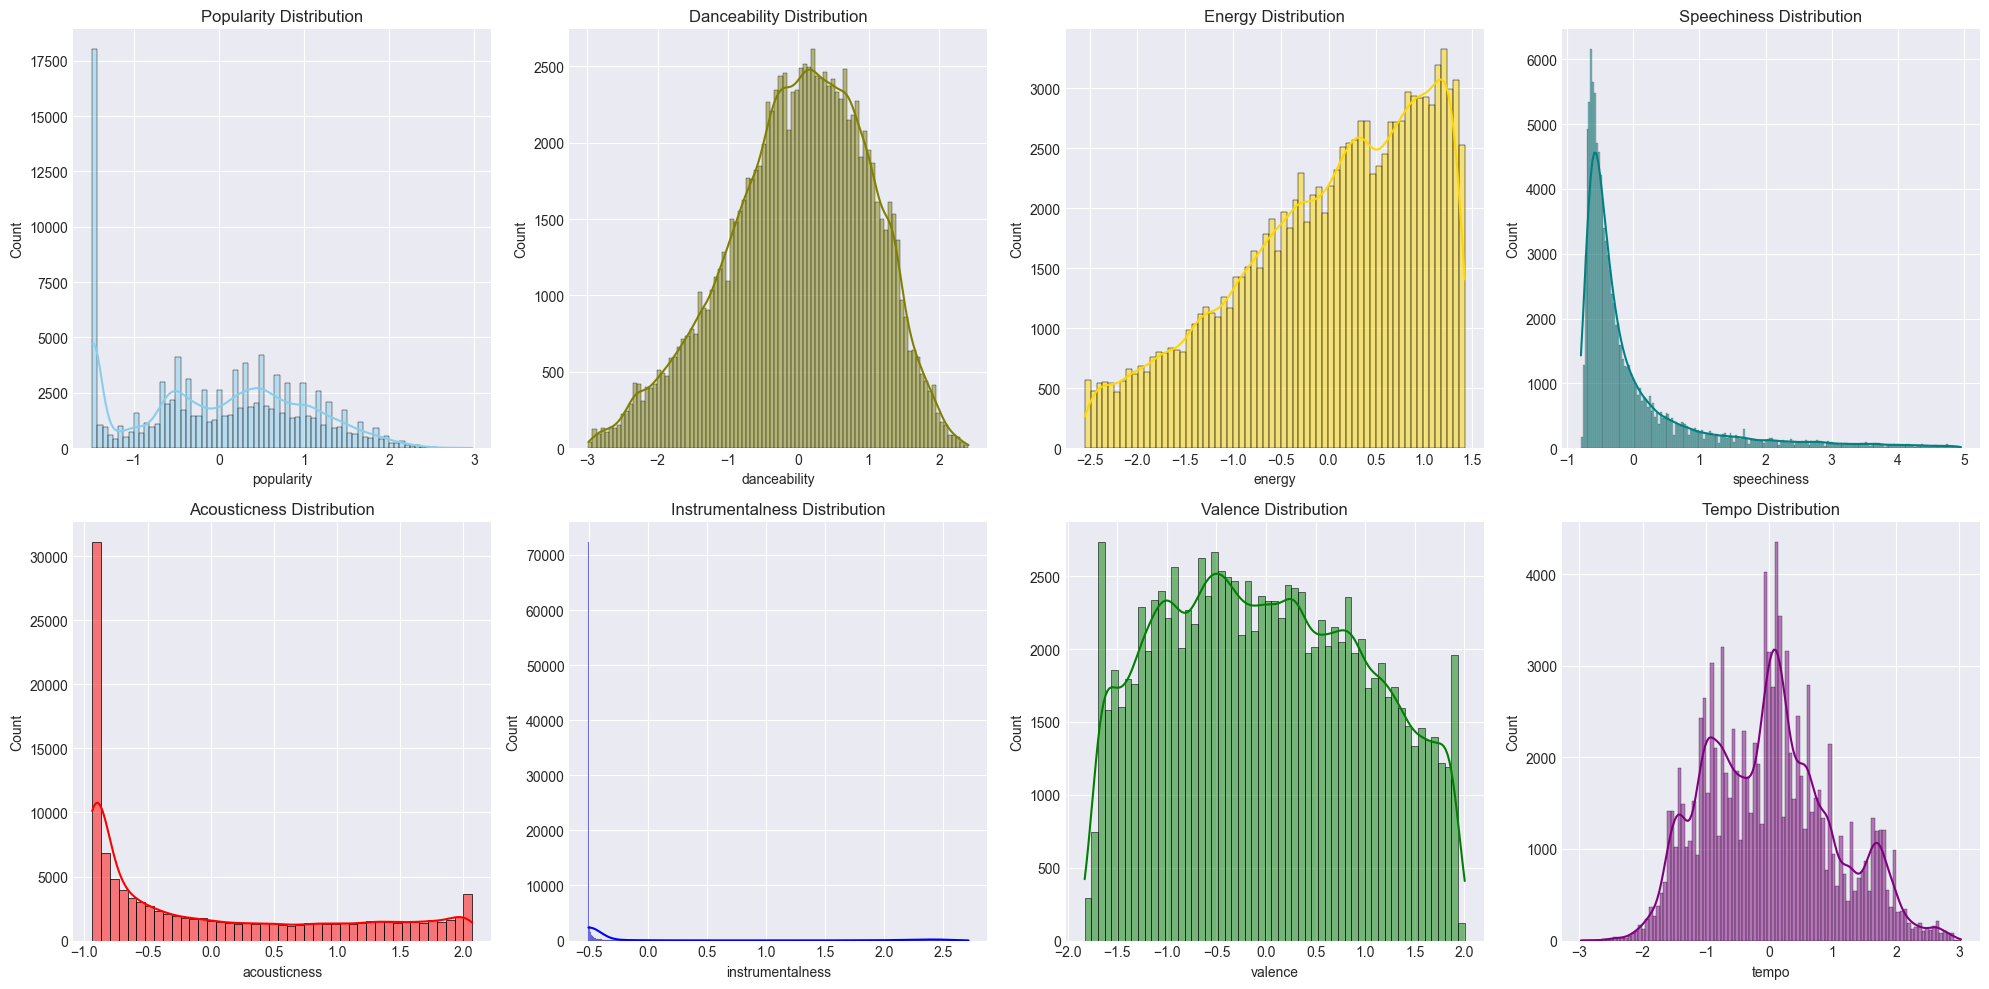

Popularity Range: -1.4867868881780375 - 2.976461810158765
Danceability Range: -2.9839865650716213 - 2.4193148335031305
Energy Range: -2.5527259665183046 - 1.4254067887779802
Speechiness Range: -0.789198897525081 - 4.95272827403704
Acousticness Range: -0.9386290433875079 - 2.069527629512441
Instrumentalness Range: -0.507340975391395 - 2.7118727670933334
Valence Range: -1.8307681982114639 - 2.0063847412786466
Tempo Range: -2.9748467359893196 - 3.0267255824392745


In [44]:
#plotting different distributions of the audio features
import matplotlib.pyplot as plt
import seaborn as sns

#styling the plot
plt.style.use('seaborn-v0_8-darkgrid')

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot the distribution of popularity
sns.histplot(df_scaled['popularity'], kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Popularity Distribution')

# Plot the distribution of danceability
sns.histplot(df_scaled['danceability'], kde=True, color='olive', ax=axes[0, 1])
axes[0, 1].set_title('Danceability Distribution')

# Plot the distribution of energy
sns.histplot(df_scaled['energy'], kde=True, color='gold', ax=axes[0, 2])
axes[0, 2].set_title('Energy Distribution')

# Plot the distribution of speechiness
sns.histplot(df_scaled['speechiness'], kde=True, color='teal', ax=axes[0, 3])
axes[0, 3].set_title('Speechiness Distribution')

# Plot the distribution of acousticness
sns.histplot(df_scaled['acousticness'], kde=True, color='red', ax=axes[1, 0])
axes[1, 0].set_title('Acousticness Distribution')

# Plot the distribution of instrumentalness
sns.histplot(df_scaled['instrumentalness'], kde=True, color='blue', ax=axes[1, 1])
axes[1, 1].set_title('Instrumentalness Distribution')

# Plot the distribution of valence
sns.histplot(df_scaled['valence'], kde=True, color='green', ax=axes[1, 2])
axes[1, 2].set_title('Valence Distribution')

# Plot the distribution of tempo
sns.histplot(df_scaled['tempo'], kde=True, color='purple', ax=axes[1, 3])
axes[1, 3].set_title('Tempo Distribution')

# Display the plots
plt.tight_layout()
plt.show()

#printing the range of each audio feature
print('Popularity Range:', df_scaled['popularity'].min(), '-', df_scaled['popularity'].max())
print('Danceability Range:', df_scaled['danceability'].min(), '-', df_scaled['danceability'].max())
print('Energy Range:', df_scaled['energy'].min(), '-', df_scaled['energy'].max())
print('Speechiness Range:', df_scaled['speechiness'].min(), '-', df_scaled['speechiness'].max())
print('Acousticness Range:', df_scaled['acousticness'].min(), '-', df_scaled['acousticness'].max())
print('Instrumentalness Range:', df_scaled['instrumentalness'].min(), '-', df_scaled['instrumentalness'].max())
print('Valence Range:', df_scaled['valence'].min(), '-', df_scaled['valence'].max())
print('Tempo Range:', df_scaled['tempo'].min(), '-', df_scaled['tempo'].max())


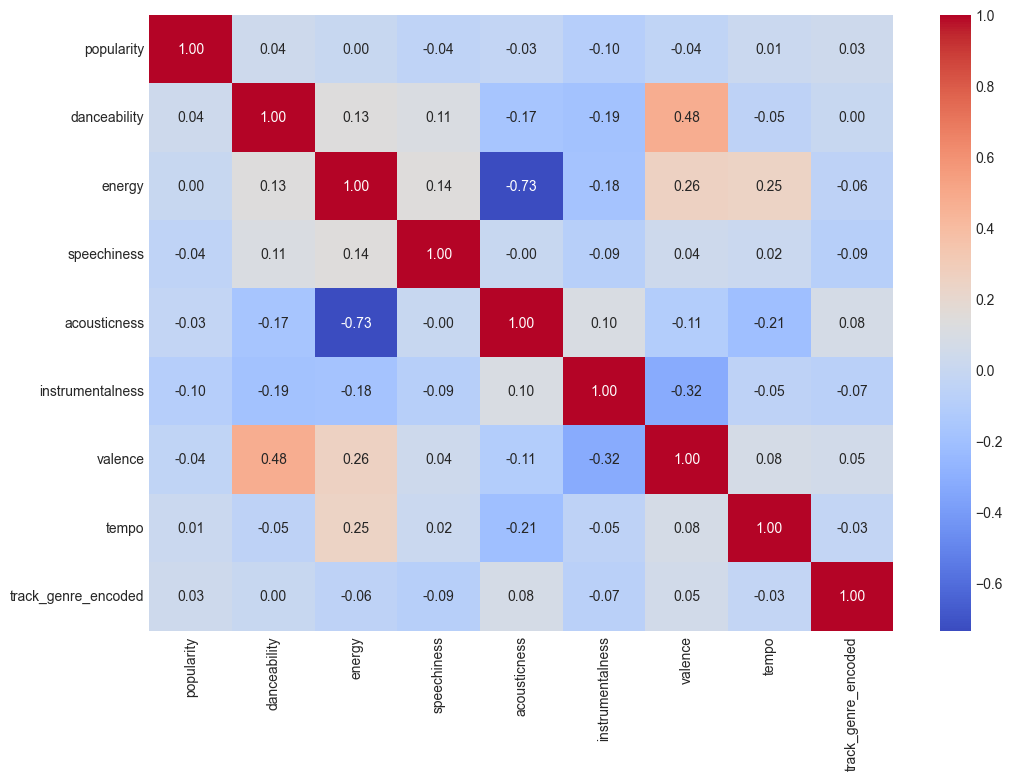

In [23]:
#geerating correlation matrix
correlation_matrix = df_scaled[['popularity', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre_encoded']].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Display the plot
plt.show()

In [47]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Defining the features
features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre_encoded']

def recommend_songs(user_songs, df, features, top_n=5):
    """
    Recommend songs based on a list of user input songs.
    
    Parameters:
    - user_songs: List of song_ids representing user's current playlist or preferences.
    - df: The DataFrame containing the song dataset.
    - features: List of features to be used for similarity calculation.
    - top_n: Number of recommendations to return.
    
    Returns:
    - DataFrame with recommended song details sorted by popularity.
    """
    
    # Filter the dataset to get the user's songs
    user_songs_df = df[df['song_id'].isin(user_songs)]
    
    # Compute cosine similarity between all user songs and all songs in the dataset
    similarity_matrix = cosine_similarity(user_songs_df[features], df[features])
    
    # Aggregate the similarity scores across all user songs
    aggregated_similarities = similarity_matrix.mean(axis=0)
    
    # Add the similarity scores to the dataframe
    df['similarity'] = aggregated_similarities
    
    # Exclude the user's input songs from the recommendations
    recommendations = df[~df['song_id'].isin(user_songs)]
    
    # Sort by similarity score (and by popularity as a secondary sort if available)
    recommendations = recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
    
    # Get the top N recommendations
    recommended_songs_df = recommendations.head(top_n)
    
    return recommended_songs_df

# Example usage:
user_songs = [100, 122, 245, 265, 608, 920, 450, 23]  # Replace with actual song_ids from the dataset
recommended_songs = recommend_songs(user_songs, df_scaled, features, top_n=5)

# Print the recommended songs
print("Recommended Songs: ")
for index, row in recommended_songs.iterrows():
    print(f"Song ID: {row['song_id']}, Similarity: {row['similarity']:0.4f}")
    print(f"Song Details: {row['track_name']} by {row['artist_name']}")
    print("\n")


Recommended Songs: 
Song ID: 829.0, Similarity: 0.7808
Song Details: Now We're Starting Over Again by Suy Galvez


Song ID: 210.0, Similarity: 0.7765
Song Details: Perfect / Style by Jonah Baker


Song ID: 657.0, Similarity: 0.7726
Song Details: Shame by Ciaran Lavery


Song ID: 50.0, Similarity: 0.7705
Song Details: Trampoline - Acoustic by Highland Peak


Song ID: 336.0, Similarity: 0.7691
Song Details: Big Love, Small Moments by JJ Heller


